# Data analysis

This notebook is the second part of the Ebay sentiment analysis project. 
The downloaded reviews were analized and cleaned for modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
pd.set_option('display.max_rows', 500)

__Loading the datasets. There are two files with data, because Ebay reviews were downloaded in two steps.__
__Note: many reviews are duplicated, this issue is resolved later__

In [4]:
data = pd.read_csv('ebay_reviews.csv', index_col='Unnamed: 0')
data2 = pd.read_csv('ebay_reviews30122020.csv', index_col='Unnamed: 0')
data = pd.concat([data, data2])

In [5]:
data.head()

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5


In [6]:
data.shape

(99612, 4)

## Data cleaning transformers

In [7]:
class DuplicatesRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to remove duplicated rows.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        duplicated_idx = X2.duplicated()
        X2 = X2[~duplicated_idx].dropna()
        return X2.set_index(np.arange(X2.shape[0]))

In [27]:
class ForeignReviewsRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to remove non-english reviews.
    If no word from the common-english-wordslist is found in a review/title
    the row is treated as nonenglish

    see_dismissed - if True non-english rows are displayed
    """

    def __init__(self, see_dismissed=False):
        words = stopwords.words('english')
        additional_words = [
            'good', 'beautiful', 'great', 'best', 'well', 'work', 'working',
            'excellent', 'price', 'nice', 'handy', 'bad', 'terrible', 'worse',
            'worst', 'broken', 'no', 'useless', 'ok', 'yes', 'fine', 'ok',
            'awesome', 'awful', 'low', 'high', 'cool'
            ]
        words_to_remove = {'i', 'me', 'a', 'd', 'o', 'y', 's', 't', 'don', 'ma'}
        words.extend(additional_words)
        self.words = list(set(words).difference(words_to_remove))
        self.see_dismissed = see_dismissed

    def fit(self, X, y=None, user_words=[]):
        self.words.extend(user_words)
        self.pattern = " | ".join(self.words) + "| ".join(self.words)\
        + " |".join(self.words)
        return self

    def transform(self, X):
        X2 = X.copy()

        X_temp = pd.DataFrame()
        cols_to_join = []

        for col in X2.columns:
            if not X2.loc[:, col].dtypes == int:
                cols_to_join.append(col)

        X_temp['connected'] = X2[cols_to_join].astype(str) \
                              .agg(' '.join, axis=1)
        idx = np.where(
            X_temp['connected'].str.contains(
                self.pattern, case=False, regex=True
                ).values == True, True, False)

        if self.see_dismissed:
            for row in X2['connected'][~idx]:
                print(row)
        return X2[idx]

In [13]:
class TextCleaning(BaseEstimator, TransformerMixin):
    """
    Transformer to remove punctation and multiple spaces from text
    and change uppercase letters to lowercase.
    """
    def __init__(self, pattern="[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]"):
        self.pattern = pattern

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        X2.replace({"\s\s+": " "}, regex=False, inplace=True)

        for col in X2.columns:
            if X2.loc[:, col].dtypes == int:
                continue
            X2.loc[:, col] = \
            X2.loc[:, col].str.replace(self.pattern, "", regex=True).str.lower()
        return X2

In [14]:
class StopWordsRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to remove popular english words with some default
    exceptions. User can add his own words to keep.
    """

    def __init__(self, words_to_keep=[
        'few', 'not', 'off', 'all', 'any', 'not', 'no', 'very'
    ]):
        stop_words = set(stopwords.words('english'))
        self.eng_words = stop_words.difference(set(words_to_keep))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()

        for col in X2.columns:
            if X2.loc[:, col].dtypes == int:
                continue
            for en, review in enumerate(X2.loc[:, col].astype(str)):
                new = (" ").join(
                    j for j in review.split(" ") 
                    if j.lower() not in self.eng_words
                )
                try:
                    X2.loc[:, col].iloc[en] = new
                except:
                    continue
        return X2

In [16]:
class Stemmer(BaseEstimator, TransformerMixin):
    """
    Transformer to stemm words.
    stem - if False the words are not stemmed (for experimental reasons)
    """

    def __init__(self, stem=True):
        self.stemmer = nltk.PorterStemmer()
        self.stem = stem

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not self.stem:
            return X
        else:
            X2 = X.copy()
            for col in X2.columns:
                if X2.loc[:, col].dtypes == int:
                    continue
                for en, review in enumerate(X2.loc[:, col].astype(str)):
                    new = (" ").join(self.stemmer.stem(j)
                                     for j in review.split(" "))
                    try:
                        X2[:, col].iloc[en] = new
                    except:
                        continue
            return X2

In [17]:
class Connector(BaseEstimator, TransformerMixin):
    """
    Transformer to connect columns in one column.
    """
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        X3 = pd.DataFrame()
        cols_to_join = []
        for col in X2.columns:
            if X2.loc[:, col].dtypes == int:
                X3['rating'] = X2.loc[:, col]     
            else:
                cols_to_join.append(col)
                
        X3['review'] = X2[cols_to_join].astype(str).agg(' '.join, axis=1)
        return X3

In [19]:
class Rating(BaseEstimator, TransformerMixin):
    """
    Transformer to change reviews ratings numbers
    labels_to_del - a list of reviews rating to remove (the assumption is that only ratings with 3 starts will be removed)
    """
    def __init__(self, scale={1:1, 2:1, 3:0, 4:0, 5:0}, labels_to_del=[]):
        self.scale = scale
        self.labels_to_del = labels_to_del
    
    def fit(self, X, y=None):
        if self.labels_to_del != []:
            self.idx_to_del = X['rating'] == self.labels_to_del[0]
        return self

    def transform(self, X):    
        X2 = X.copy()
        if self.labels_to_del:
            X2 = X2[~self.idx_to_del]
        X2.replace(self.scale, inplace=True)
        return X2

## Data analysis
__Removing duplicated rows__

In [20]:
dr = DuplicatesRemover()
dr.fit(data)
data_temp = dr.transform(data)

In [21]:
data_temp.shape

(44756, 4)

__Ratings counts__

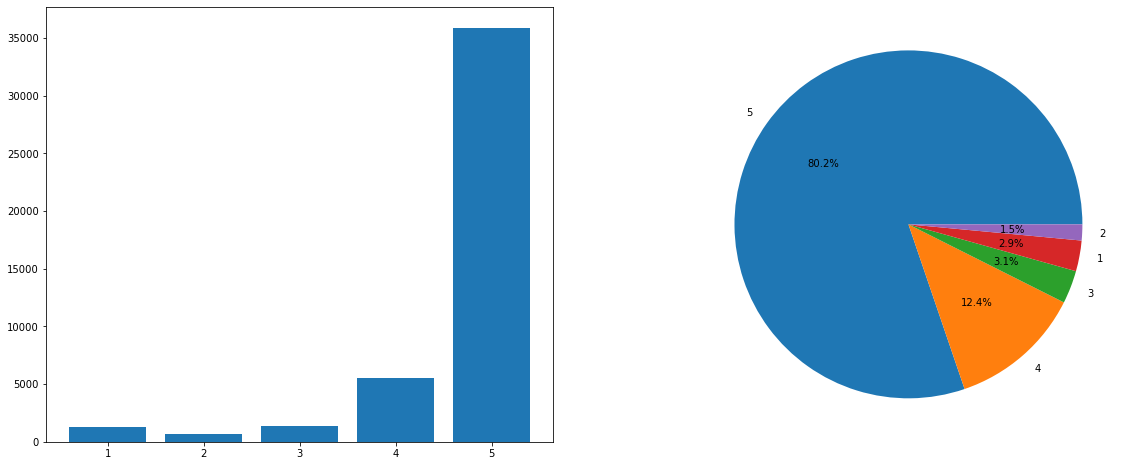

In [22]:
x = data_temp.rating.astype(int).value_counts().index
y = data_temp.rating.astype(int).value_counts().values

fig, ax = plt.subplots(ncols=2, figsize=(20,8))

ax[0].bar(x, y)
ax[1].pie(y, labels=x, autopct='%1.1f%%')
plt.show()

__Top 20 categories__

In [23]:
data_temp['category'].value_counts().head(20)

Cell Phones & Smartphones       9861
Digital Cameras                 4565
Video Games                     3588
Headphones                      3442
Cordless Drills                 1736
Video Game Consoles             1672
Monitors                        1563
Camcorders                      1514
Mice, Trackballs & Touchpads    1247
Keyboards & Keypads             1201
Smart Speakers                  1042
PC Laptops & Netbooks           1018
Reciprocating Saws               678
Apple Laptops                    583
Lenses                           573
Circular Saws                    573
Men's Shavers                    557
Media Streamers                  413
Internal Hard Disk Drives        400
Headsets                         336
Name: category, dtype: int64

__Some neutral reviews (3 stars out of 5)__

In [24]:
for comment in data_temp[data_temp['rating'] == 3]['review content'].sample(10):
    print()
    print(comment)


Took sometime to receive them

Product is good.. just like what I expected.. I added NVMe SSD..But packaging condition was so bad... Computer back plate was bent when I opened the box..Please be careful about packaging..Read full review...

I bought this controller thinking it was going to connect to my IPhone. It was my fault I did not read the full description I was just finger happy. It looks like an amazing and well put together controller I wish I could use. I now have two controllers that aren’t going to get put to use. Read description before buying! Don’t be a me. Amazing service though thank you so much!Read full review...

Device had light scratches on the screen and battery life is not good. 80% drained each day w/ light use.

At times its a challenge for the screen to come on when you double tap.  You kind of got to press a little harder. You also cant add privacy screen.   Minus those points its good product..

A little slow at the start but not too bad. Would buy again i

__Reviews preprocessing__

In the following cell the reviews are cleaned (using the transformesrs). In order to get as much information as possible the title and the review content are connected.

1 and 2 stars reviews are changed to -1, 3 starts reviews to 0, 4 and 5 stars to 1

In [28]:
#transformers for classic machine learning approach
cols = ['review title', 'review content', 'rating']

preprocessor = Pipeline([
    ('DuplicateRemover', DuplicatesRemover()),
    ('ForeignReviewsRemover', ForeignReviewsRemover()),
    ('TextCleaning', TextCleaning()),
    ('StopWordsRemover', StopWordsRemover()),
    ('Stemmer', Stemmer(stem=False)),
    ('Connector', Connector()),
    ('Rating', Rating(scale={1: -1, 2: -1, 3: 0, 4: 1, 5: 1})),
    ('DuplicateRemover2', DuplicatesRemover())
])

In [30]:
preprocessor.fit(data[cols])
data_preprocessed = preprocessor.transform(data[cols])

In [31]:
data_preprocessed.head(10)

,rating,review
0,1,wireless gaming headset gaming headset ticks ...
1,0,good big head low budget easy setup rated 6 ho...
2,1,mezumiwireless gaming headset originally bough...
3,1,hw s2 great headset 2nd mezumi headset kills f...
4,1,best headphones ive purchased entire life prob...
5,1,great headset worth 50 headsert great value re...
6,1,works well aware dose not connect xbox wirele...
7,1,haven’t worked wifi yet glad still use tho ver...
8,1,all good all good product described
9,1,good price probably best low cost headset mar...


__Wordclouds of negative, neutral and positive reviews__

In [32]:
data_preprocessed.rating.value_counts()

 1    42282
-1     2025
 0     1442
Name: rating, dtype: int64

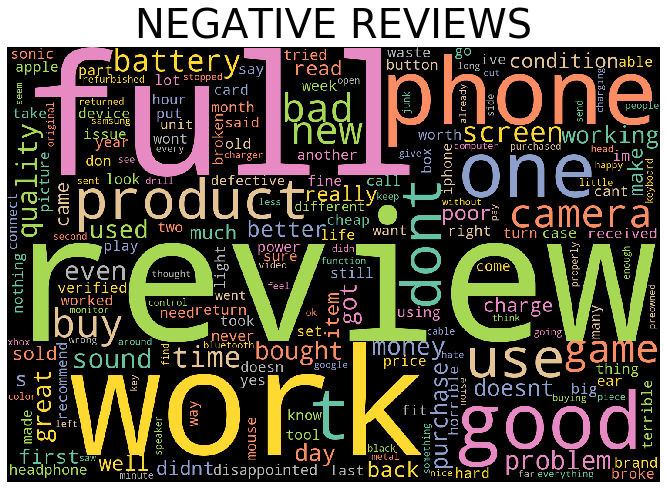

In [33]:
negative = data_preprocessed[data_preprocessed['rating'] == -1]['review']
negative_text = (" ").join(negative.tolist())
wordcloud=WordCloud(
    width=1500,
    height=1000,
    collocations=False,
    colormap='Set2'
).generate(negative_text)

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('NEGATIVE REVIEWS', fontsize=40)
plt.show()

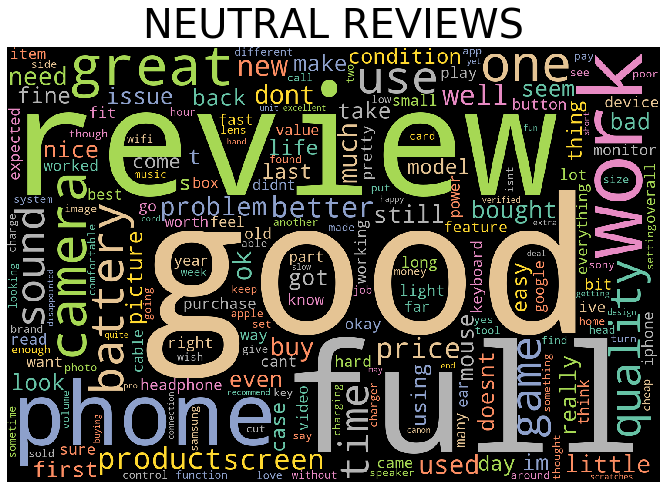

In [34]:
negative = data_preprocessed[data_preprocessed['rating'] == 0]['review']
negative_text = (" ").join(negative.tolist())
wordcloud = WordCloud(
    width=1500,
    height=1000,
    collocations=False,
    colormap='Set2').generate(negative_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('NEUTRAL REVIEWS', fontsize=40)
plt.show()

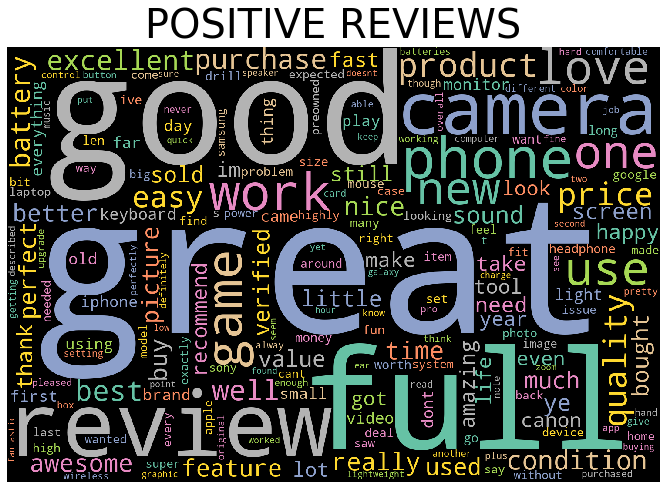

In [35]:
positive = data_preprocessed[data_preprocessed['rating'] == 1]['review']
posivite_text = (" ").join(positive.tolist())
wordcloud = WordCloud(
    width=1500,
    height=1000,
    collocations=False,
    colormap='Set2').generate(posivite_text)

plt.figure(figsize=(12, 8)) 
plt.imshow(wordcloud) 
plt.title('POSITIVE REVIEWS', fontsize=40)
plt.axis("off") 
plt.show()

In [36]:
data_preprocessed.rating.value_counts()

 1    42282
-1     2025
 0     1442
Name: rating, dtype: int64

__TfidfVectorizer parameters__

TfidfVectorizer will be used in classic machine learning approach. Some different values of parameters were tested to select the most reasonable.

__Default matrix size__

In [37]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(data_preprocessed['review']).todense().shape

(45749, 50753)

__Different parameters values were tested, the most reasonable result is shown below__

In [38]:
#min_df -  When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
#max_df = When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold

tfidf = TfidfVectorizer(min_df=50)
tfidf.fit_transform(data_preprocessed['review']).todense().shape

(45749, 2095)

__Transforming data for modelling__

1. Classic machine learning approach - these have been already preprocessed

In [39]:
data_preprocessed.to_csv('Data_ML.csv', index=True)

2. Neural Networks

In this case data cleaning slightly differs - punctuation is kept

Note: Rating numbers are adjusted directly in neural network notebook

In [40]:
cols = ['review title', 'review content', 'rating']
    
preprocessor_NN = Pipeline([
    ('DuplicateRemover', DuplicatesRemover()),
    ('TextCleaning', TextCleaning(pattern="[\"#\*\+/<=>@[\\]^_`{|}~]")),
    ('ForeignReviewsRemover',ForeignReviewsRemover()),
    ('Connector', Connector()),
    ('Rating', Rating(scale={1:0, 2:0, 3:3, 4:1, 5:1}))
])

preprocessor_NN.fit(data[cols])
data_preprocessed_NN = preprocessor_NN.transform(data[cols])
data_preprocessed_NN.to_csv('Data_NN.csv', index=True)